In [1]:
# Imports
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_leon

# Create Training and Test Sets

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


(504,
 504,
 Counter({1: 54,
          2: 49,
          4: 50,
          5: 51,
          8: 52,
          9: 52,
          0: 48,
          3: 50,
          6: 48,
          7: 50}))

In [3]:
# define synthetic data directory
output_dir = 'synthetic_data/output'
output_list = os.listdir(output_dir)

X_paths = [] # paths of segment folders
y = [] # designated label

for output_folder in output_list:
    if output_folder.startswith('vid'):
        x_path = output_dir + '/' + output_folder
        X_paths.append(x_path)
        
        # Extract class label from folder name
        params = re.findall(r'\d+', output_folder)
        label = int(int(params[3]) / 200)
        y.append(label)
        
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        # extract features
        X_pts = data['subset_all'].reshape(data['subset_all'].shape[0],60)
        X_feat = data['candidate_all']
        for frame in range(X_pts.shape[0]):
            X_occluded = np.where(X_pts[frame] == -1)
            X_feat[frame][X_pts[frame] == -1, :] = -1
        # only use body markers 0-17
        non_markers = [18,19,38,39,58,59]
        X_feat = X_feat[:20,:,0:2] # use 50 frames # try reshaping into 3 channels
        X_feat[:,0:17,0] -= np.mean(X_feat[:,0:17,0])
        X_feat[:,0:17,0] /= np.std(X_feat[:,0:17,0])
        X_feat[:,20:37,0] -= np.mean(X_feat[:,20:37,0])
        X_feat[:,20:37,0] /= np.std(X_feat[:,20:37,0])
        X_feat[:,40:57,0] -= np.mean(X_feat[:,40:57,0])
        X_feat[:,40:57,0] /= np.std(X_feat[:,40:57,0])
        X_feat[:,0:17,1] -= np.mean(X_feat[:,0:17,1])
        X_feat[:,0:17,1] /= np.std(X_feat[:,0:17,1])
        X_feat[:,20:37,1] -= np.mean(X_feat[:,20:37,1])
        X_feat[:,20:37,1] /= np.std(X_feat[:,20:37,1])
        X_feat[:,40:57,1] -= np.mean(X_feat[:,40:57,1])
        X_feat[:,40:57,1] /= np.std(X_feat[:,40:57,1])
        X_feat = np.squeeze(np.delete(X_feat, non_markers, axis=1).reshape(20,-1))
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

(854, 854, Counter({2: 172, 4: 170, 3: 169, 0: 128, 1: 172, 5: 43}))

In [4]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (768,768)
Test Set: (86,86)


In [5]:
# define normalization
class norm_per_keypt(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=1)
        sub2 = normalize(sample[:,56:112], axis=1)
        sub3 = normalize(sample[:,112:168], axis=1)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample
    
class norm_over_frames(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample, axis=1)
        return scaled_sample
    
class norm_over_all(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample)
        return scaled_sample
    
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0), 

class norm_with_saved(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [6]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor(),
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

In [7]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [8]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 108]) torch.Size([30])
torch.Size([30, 20, 108]) torch.Size([30])


In [9]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 108
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame) #, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        
        return output

In [10]:
# RNN Model Parameter
model_params = {
    "num_classes": 10,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)

In [11]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 108)
    y = model(x)
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 10])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cuda:0


SyncRNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(108, 100)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
)

In [13]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")
#loss_fn = nn.MSELoss(reduction="sum")

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.1) #3e-5 # 3e-3

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 70,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_leon_mod.pt",
}

In [14]:
trained_model, loss_hist, metric_hist = trainutils_leon.train_model(model, train_params)

Epoch 0/69, current_lr=0.1



Saved best model weights
Train Loss: 1.999801, Dev Loss: 1.949303, Accuracy: 19.77
----------
Epoch 1/69, current_lr=0.1



Train Loss: 1.963484, Dev Loss: 1.984965, Accuracy: 19.77
----------
Epoch 2/69, current_lr=0.1



Train Loss: 1.903075, Dev Loss: 2.136837, Accuracy: 17.44
----------
Epoch 3/69, current_lr=0.1



Saved best model weights
Train Loss: 1.945605, Dev Loss: 1.852744, Accuracy: 18.60
----------
Epoch 4/69, current_lr=0.1



Saved best model weights
Train Loss: 1.875197, Dev Loss: 1.795404, Accuracy: 25.58
----------
Epoch 5/69, current_lr=0.1



Train Loss: 1.871335, Dev Loss: 1.977571, Accuracy: 17.44
----------
Epoch 6/69, current_lr=0.1



Train Loss: 1.875716, Dev Loss: 1.994301, Accuracy: 18.60
----------
Epoch 7/69, current_lr=0.1



Train Loss: 1.917054, Dev Loss: 2.378307, Accuracy: 19.77
----------
Epoch 8/69, current_lr=0.1



Train Loss: 2.000364, Dev Loss: 2.065621, Accuracy: 23.26
----------
Epoch 9/69, current_lr=0.1



Train Loss: 1.930920, Dev Loss: 2.067410, Accuracy: 20.93
----------
Epoch 10/69, current_lr=0.1



Saved best model weights
Train Loss: 1.955083, Dev Loss: 1.765028, Accuracy: 22.09
----------
Epoch 11/69, current_lr=0.1



Train Loss: 1.963349, Dev Loss: 1.993155, Accuracy: 20.93
----------
Epoch 12/69, current_lr=0.1



Train Loss: 1.949176, Dev Loss: 2.506835, Accuracy: 20.93
----------
Epoch 13/69, current_lr=0.1



Train Loss: 1.979645, Dev Loss: 1.936650, Accuracy: 20.93
----------
Epoch 14/69, current_lr=0.1



Train Loss: 1.986180, Dev Loss: 1.993406, Accuracy: 20.93
----------
Epoch 15/69, current_lr=0.1



Train Loss: 1.903390, Dev Loss: 2.268174, Accuracy: 22.09
----------
Epoch 16/69, current_lr=0.1



Epoch    17: reducing learning rate of group 0 to 7.0000e-02.
Loading best model weights
Train Loss: 1.989231, Dev Loss: 2.039540, Accuracy: 22.09
----------
Epoch 17/69, current_lr=0.06999999999999999



Train Loss: 1.823547, Dev Loss: 1.935349, Accuracy: 20.93
----------
Epoch 18/69, current_lr=0.06999999999999999



Saved best model weights
Train Loss: 1.803822, Dev Loss: 1.752651, Accuracy: 22.09
----------
Epoch 19/69, current_lr=0.06999999999999999



Train Loss: 1.821906, Dev Loss: 1.788500, Accuracy: 16.28
----------
Epoch 20/69, current_lr=0.06999999999999999



Train Loss: 1.819418, Dev Loss: 1.793483, Accuracy: 15.12
----------
Epoch 21/69, current_lr=0.06999999999999999



Train Loss: 1.850767, Dev Loss: 1.919135, Accuracy: 20.93
----------
Epoch 22/69, current_lr=0.06999999999999999



Train Loss: 1.830378, Dev Loss: 1.793095, Accuracy: 19.77
----------
Epoch 23/69, current_lr=0.06999999999999999



Train Loss: 1.810095, Dev Loss: 1.812105, Accuracy: 19.77
----------
Epoch 24/69, current_lr=0.06999999999999999



Epoch    25: reducing learning rate of group 0 to 4.9000e-02.
Loading best model weights
Train Loss: 1.833814, Dev Loss: 1.940935, Accuracy: 19.77
----------
Epoch 25/69, current_lr=0.048999999999999995



Train Loss: 1.773317, Dev Loss: 1.841302, Accuracy: 19.77
----------
Epoch 26/69, current_lr=0.048999999999999995



Train Loss: 1.782797, Dev Loss: 1.823608, Accuracy: 19.77
----------
Epoch 27/69, current_lr=0.048999999999999995



Train Loss: 1.783091, Dev Loss: 1.791112, Accuracy: 17.44
----------
Epoch 28/69, current_lr=0.048999999999999995



Train Loss: 1.778903, Dev Loss: 1.796039, Accuracy: 18.60
----------
Epoch 29/69, current_lr=0.048999999999999995



Train Loss: 1.785483, Dev Loss: 1.869995, Accuracy: 18.60
----------
Epoch 30/69, current_lr=0.048999999999999995



Saved best model weights
Train Loss: 1.754869, Dev Loss: 1.749258, Accuracy: 22.09
----------
Epoch 31/69, current_lr=0.048999999999999995



Train Loss: 1.775690, Dev Loss: 1.766158, Accuracy: 17.44
----------
Epoch 32/69, current_lr=0.048999999999999995



Train Loss: 1.775894, Dev Loss: 1.756930, Accuracy: 17.44
----------
Epoch 33/69, current_lr=0.048999999999999995



Train Loss: 1.770198, Dev Loss: 1.780091, Accuracy: 19.77
----------
Epoch 34/69, current_lr=0.048999999999999995



Train Loss: 1.733335, Dev Loss: 1.801811, Accuracy: 22.09
----------
Epoch 35/69, current_lr=0.048999999999999995



Train Loss: 1.758742, Dev Loss: 1.831572, Accuracy: 18.60
----------
Epoch 36/69, current_lr=0.048999999999999995



Epoch    37: reducing learning rate of group 0 to 3.4300e-02.
Loading best model weights
Train Loss: 1.768819, Dev Loss: 1.830384, Accuracy: 22.09
----------
Epoch 37/69, current_lr=0.0343



Train Loss: 1.734856, Dev Loss: 1.768570, Accuracy: 18.60
----------
Epoch 38/69, current_lr=0.0343



Train Loss: 1.749068, Dev Loss: 1.785637, Accuracy: 19.77
----------
Epoch 39/69, current_lr=0.0343



Saved best model weights
Train Loss: 1.743628, Dev Loss: 1.745442, Accuracy: 19.77
----------
Epoch 40/69, current_lr=0.0343



Saved best model weights
Train Loss: 1.742651, Dev Loss: 1.739686, Accuracy: 17.44
----------
Epoch 41/69, current_lr=0.0343



Train Loss: 1.738555, Dev Loss: 1.856138, Accuracy: 19.77
----------
Epoch 42/69, current_lr=0.0343



Train Loss: 1.795484, Dev Loss: 1.797000, Accuracy: 19.77
----------
Epoch 43/69, current_lr=0.0343



Train Loss: 1.799901, Dev Loss: 1.765478, Accuracy: 20.93
----------
Epoch 44/69, current_lr=0.0343



Saved best model weights
Train Loss: 1.736735, Dev Loss: 1.698314, Accuracy: 17.44
----------
Epoch 45/69, current_lr=0.0343



Train Loss: 1.717915, Dev Loss: 1.852740, Accuracy: 19.77
----------
Epoch 46/69, current_lr=0.0343



Train Loss: 1.755891, Dev Loss: 1.846525, Accuracy: 22.09
----------
Epoch 47/69, current_lr=0.0343



Train Loss: 1.732508, Dev Loss: 1.762015, Accuracy: 22.09
----------
Epoch 48/69, current_lr=0.0343



Train Loss: 1.750339, Dev Loss: 1.823834, Accuracy: 19.77
----------
Epoch 49/69, current_lr=0.0343



Train Loss: 1.777359, Dev Loss: 1.711683, Accuracy: 19.77
----------
Epoch 50/69, current_lr=0.0343



Epoch    51: reducing learning rate of group 0 to 2.4010e-02.
Loading best model weights
Train Loss: 1.774161, Dev Loss: 1.737017, Accuracy: 22.09
----------
Epoch 51/69, current_lr=0.024009999999999997



Train Loss: 1.717712, Dev Loss: 1.764783, Accuracy: 19.77
----------
Epoch 52/69, current_lr=0.024009999999999997



Train Loss: 1.740286, Dev Loss: 1.729115, Accuracy: 20.93
----------
Epoch 53/69, current_lr=0.024009999999999997



Train Loss: 1.718043, Dev Loss: 1.715883, Accuracy: 22.09
----------
Epoch 54/69, current_lr=0.024009999999999997



Train Loss: 1.724099, Dev Loss: 1.732903, Accuracy: 19.77
----------
Epoch 55/69, current_lr=0.024009999999999997



Train Loss: 1.731609, Dev Loss: 1.736767, Accuracy: 22.09
----------
Epoch 56/69, current_lr=0.024009999999999997



Epoch    57: reducing learning rate of group 0 to 1.6807e-02.
Loading best model weights
Train Loss: 1.710956, Dev Loss: 1.735137, Accuracy: 18.60
----------
Epoch 57/69, current_lr=0.016806999999999996



Train Loss: 1.721488, Dev Loss: 1.710415, Accuracy: 19.77
----------
Epoch 58/69, current_lr=0.016806999999999996



Train Loss: 1.719938, Dev Loss: 1.734467, Accuracy: 23.26
----------
Epoch 59/69, current_lr=0.016806999999999996



Train Loss: 1.713000, Dev Loss: 1.727744, Accuracy: 19.77
----------
Epoch 60/69, current_lr=0.016806999999999996



Train Loss: 1.711901, Dev Loss: 1.786391, Accuracy: 20.93
----------
Epoch 61/69, current_lr=0.016806999999999996



Train Loss: 1.761777, Dev Loss: 1.747479, Accuracy: 20.93
----------
Epoch 62/69, current_lr=0.016806999999999996



Saved best model weights
Train Loss: 1.704076, Dev Loss: 1.697969, Accuracy: 22.09
----------
Epoch 63/69, current_lr=0.016806999999999996



Train Loss: 1.706797, Dev Loss: 1.727047, Accuracy: 19.77
----------
Epoch 64/69, current_lr=0.016806999999999996



Train Loss: 1.719597, Dev Loss: 1.755228, Accuracy: 22.09
----------
Epoch 65/69, current_lr=0.016806999999999996



Train Loss: 1.711401, Dev Loss: 1.731228, Accuracy: 18.60
----------
Epoch 66/69, current_lr=0.016806999999999996



Train Loss: 1.714909, Dev Loss: 1.718419, Accuracy: 18.60
----------
Epoch 67/69, current_lr=0.016806999999999996



Saved best model weights
Train Loss: 1.708604, Dev Loss: 1.695277, Accuracy: 19.77
----------
Epoch 68/69, current_lr=0.016806999999999996



Train Loss: 1.716072, Dev Loss: 1.703693, Accuracy: 19.77
----------
Epoch 69/69, current_lr=0.016806999999999996



Train Loss: 1.712055, Dev Loss: 1.745241, Accuracy: 19.77
----------


In [16]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x.to(device))
        idx = y.argmax(dim=2)
        print(idx)
    break

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [4],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]], device='cuda:0')


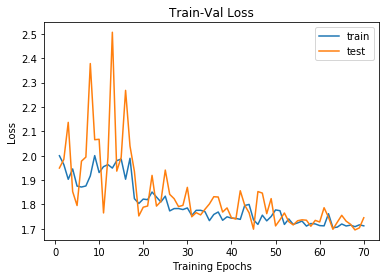

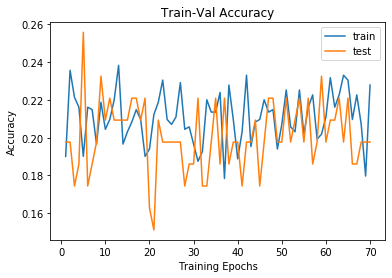

In [17]:
trainutils_leon.plot_loss(loss_hist, metric_hist)